# Import

In [1]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import re
import contractions
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import collections
import math
import pickle


import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = set(stopwords.words("english"))

import torchtext
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import Dataset, DataLoader, random_split 
from torch import nn
import torch 

from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print('device = ', DEVICE)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


device =  cuda


In [2]:
print(STOPWORDS)

{'too', 'where', 'here', 'this', 'has', 'after', 'him', 'on', 'so', "doesn't", 'is', 'ain', 'not', 'myself', 'what', 's', 'shouldn', "it's", 'off', 'over', 'above', 'have', 'd', "you've", 'am', 'won', 'out', 'she', 'them', 'any', 'yourself', 'did', 'now', 'under', 'was', 'below', "haven't", 'few', 'o', "mustn't", "mightn't", 'themselves', 'had', 'my', 'ourselves', 'there', 'hasn', 'during', 'than', 'just', "you'd", 'as', 'wasn', 'which', 'through', 'only', 'who', 'such', 'needn', 'they', 'if', 'before', 'each', 'hers', 'about', 'more', 'until', 'up', 've', 'yours', "hadn't", "weren't", 'the', 'very', 'he', 'their', 'an', 'same', "couldn't", 'mustn', 'me', 'when', 'we', "hasn't", 'for', 'no', 'will', 'm', 'a', 'doesn', 'been', 'but', 'because', "that'll", 'nor', 'all', 'of', 'couldn', 'does', 'll', 'do', 'you', 'its', 'down', 'that', 'her', 'wouldn', 'haven', 'against', "isn't", 'be', 'with', 'yourselves', 'by', "shan't", 'hadn', "aren't", "shouldn't", 'itself', 'your', "should've", 'sh

#  Hyperparams

In [3]:
ROOT = os.getcwd()
DATASET_PATH = os.path.join(ROOT, 'dataset', 'amazon_full' )
ALL_DF_CSV = os.path.join(DATASET_PATH, 'all_df.csv')

OUTPUT_PATH = os.path.join(ROOT, 'output', 'bert')

TRAIN_DATAPATH = os.path.join(DATASET_PATH, 'train.csv')
TEST_DATAPATH = os.path.join(DATASET_PATH, 'test.csv')

SAMPLE_SIZE = 0.2
TEST_SAMPLE_SIZE = 0.1

CLEANED_TRAIN_DATAPATH = os.path.join(DATASET_PATH, f'cleaned_train_{int(SAMPLE_SIZE*100)}%.csv')
CLEANED_TEST_DATAPATH = os.path.join(DATASET_PATH, f'cleaned_test_{int(TEST_SAMPLE_SIZE*100)}%.csv')

if os.path.exists(OUTPUT_PATH) == False:
    os.makedirs(OUTPUT_PATH)


# Load the whole dataset and truncate it (for experiments)

In [4]:
# train_txt = bz2.BZ2File(os.path.join(datasetpath, 'train.ft.txt.bz2'))
# train_txt = bz2.BZ2File('/content/drive/MyDrive/UB/Sem 2/DL/DL FINAL Project/train.ft.txt.bz2')

# train_txt = bz2.BZ2File(DATASET_PATH)
# train_lines = train_txt.readlines()

In [5]:
train_df = pd.read_csv(TRAIN_DATAPATH, names = ["review", "title","text"])
train_df = train_df.sample(frac = SAMPLE_SIZE)
train_df.reset_index(inplace = True, drop = True)
train_df.head()
# print(train_df.shape)
label_map = {
    1: 0,
    2: 1,
    3: 2,
    4: 3,
    5: 4,
}
train_df['review'] = train_df['review'].map(label_map)
print(train_df.shape)
print(train_df['review'].value_counts())
train_df.head()

(600000, 3)
review
0    120230
1    120007
3    119964
4    119949
2    119850
Name: count, dtype: int64


,review,title,text
0,0,Even if its a classic that doesn't make it good.,I had to read this book for summer reading and...
1,4,Love the cheesehead!,I bought this product for my nephew and he lov...
2,3,Great folding outdoor chair,This is a very comfortable folding outdoor cha...
3,4,These are AWESOME,I have a mentally ill daughter that has no sel...
4,3,great and prompt,It had the song on it that we wanted and it is...


In [6]:
test_df = pd.read_csv(TEST_DATAPATH, names = ["review", "title","text"])
test_df = test_df.sample(frac = TEST_SAMPLE_SIZE)
test_df.reset_index(inplace = True, drop = True)
test_df.head()
label_map = {
    1: 0,
    2: 1,
    3: 2,
    4: 3,
    5: 4,
}
test_df['review'] = test_df['review'].map(label_map)
test_df.reset_index(inplace=True, drop = True)
print(test_df['review'].value_counts())
print(test_df.shape)
test_df.head()

review
0    13099
4    13067
1    13022
3    12978
2    12834
Name: count, dtype: int64
(65000, 3)


,review,title,text
0,0,"Yet another false ""GAS"" alarm",Allow me to join the ranks of those who have g...
1,2,not good for a BMW motorcycle,I purchased this plugs for bmw r1100r since th...
2,3,Don't Listen to the Others!,Get Smart's Bruce and Lloyd Out of ControlIt's...
3,4,"AGAIN, WONDERFUL JOB!",I have all but one of the ferret company ferre...
4,1,"Good pager, bad alarm",I do not suggest buying this alarm unless you ...


# Clean text

In [7]:
# Cleaning Text

def remove_urls(text):
    #if there's link in text, like www.something.com, https://www.something.com,
    # replace it with the <url> token
    pattern = re.compile(r'https?://\S+|www\.\S+')
    text = pattern.sub(' ', text)
    return text

def remove_digits(text):
    return re.sub("\d", ' ', text)

def remove_punctation(text):
    return re.sub(r'[^\w\s]',' ',text)

def expand_contraction(text):
    return contractions.fix(text)

def remove_stopwords(text):
    return ' '.join([word for word in text.split(' ') if word not in STOPWORDS])

def clean_text(text):
    '''
    extract feature and label from line and process the text
    @params:
        text: string, format: __label__2 some text.
    @return:
        feature: string
        label: int, 0: bad review, 1 good review
    '''
    #Each line has format: __label__2 some text.
    #The first part is label, the rest is text feature
    #lower case the features
    text = text.lower()
    #start cleaning

    #remove urls in text
    text = remove_urls(text)
    #remove digits
    text = remove_digits(text)
    # # #expand contractions
    text = expand_contraction(text)
    # # #remove punctuations
    text = remove_punctation(text)
    # # #remove stop words
    # text = remove_stopwords(text)

    #__label__1 = 0: bad review, __label__2 = 1,good review
    text = ' '.join(t for t in text.split() if t != '')
    return text.strip()

test_string = '''This is a test string. Here are some special characters: &,#,$. How about some punctuations? !@#$%^&*()_+=-`~{[]}|:;'<,>.?/"|https://www.example.com'''

clean_text(test_string)

'this is a test string here are some special characters how about some punctuations _'

In [8]:
train_df['text'] = train_df['text'].apply(lambda s: clean_text(s))
test_df['text'] = test_df['text'].apply(lambda s: clean_text(s))

# Check data integrity, missing values and bad values

In [9]:
print('train df')
train_df.dropna(inplace=True)
print(train_df.isna().sum())
print('train df = ', train_df.shape)
print('test df')
test_df.dropna(inplace=True)
print(test_df.isna().sum())
print('test df = ' ,test_df.shape)

train df
review    0
title     0
text      0
dtype: int64
train df =  (599963, 3)
test df
review    0
title     0
text      0
dtype: int64
test df =  (64996, 3)


# Save df

In [10]:
train_df.to_csv(CLEANED_TRAIN_DATAPATH, index=False)
test_df.to_csv(CLEANED_TEST_DATAPATH, index=False)


In [11]:
print(test_df.shape)
test_df.head()

(64996, 3)


,review,title,text
0,0,"Yet another false ""GAS"" alarm",allow me to join the ranks of those who have g...
1,2,not good for a BMW motorcycle,i purchased this plugs for bmw are r since the...
2,3,Don't Listen to the Others!,get smart s bruce and lloyd out of controlit s...
3,4,"AGAIN, WONDERFUL JOB!",i have all but one of the ferret company ferre...
4,1,"Good pager, bad alarm",i do not suggest buying this alarm unless you ...


In [17]:
# eda_df = train_df.copy()
# eda_df['text'] = eda_df['text'].apply(lambda s: clean_text(s))
train_df['lengths'] = train_df['text'].apply(lambda s: len(s))

test_df['lengths'] = test_df['text'].apply(lambda s: len(s))


# Stats
train_df.describe()

train max length =  1009
test max length =  996


,review,lengths
count,599963.000000,599963.000000
mean,1.999027,403.175334
std,1.414626,231.051692
min,0.000000,0.000000
25%,1.000000,207.000000
50%,2.000000,357.000000
75%,3.000000,565.000000
max,4.000000,1009.000000


In [18]:
test_df.describe()

,review,lengths
count,64996.000000,64996.000000
mean,1.998323,403.817620
std,1.417836,231.629846
min,0.000000,0.000000
25%,1.000000,207.000000
50%,2.000000,358.000000
75%,3.000000,567.000000
max,4.000000,996.000000


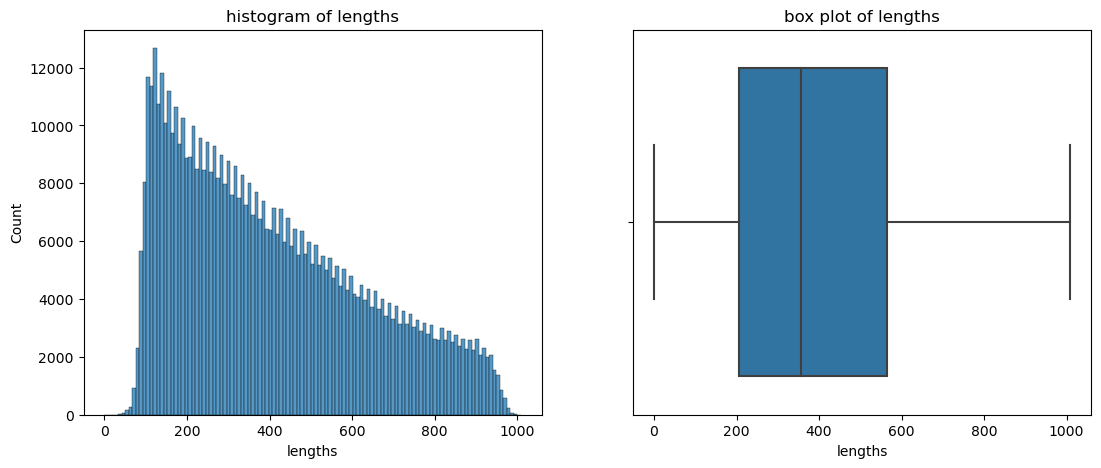

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(13,5))
sns.histplot(eda_df, x = 'lengths', ax = ax1)
ax1.set_title('histogram of lengths')
sns.boxplot(eda_df, x = 'lengths', ax = ax2)
ax2.set_title('box plot of lengths')
plt.show()

# A little EDA

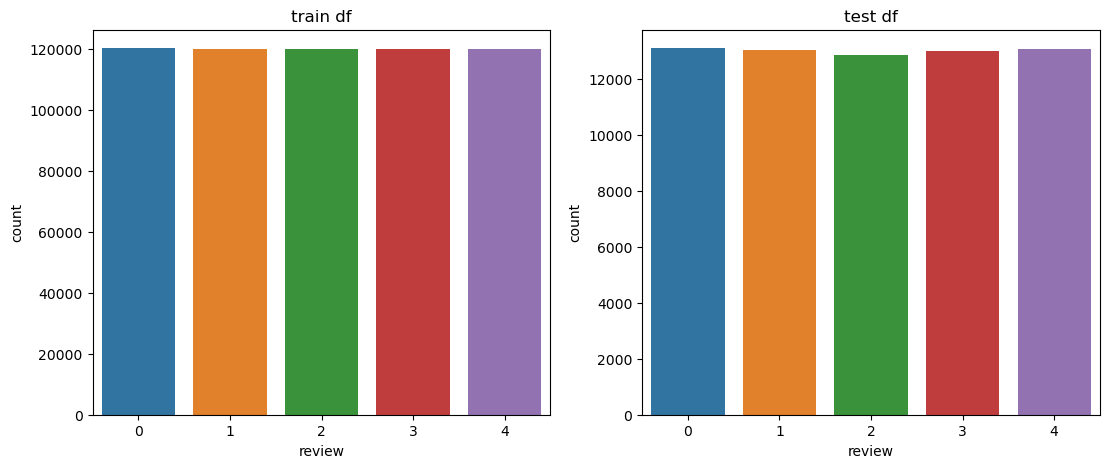

In [14]:
# bad_reviews = eda_df.loc[eda_df['review'] == 1]['text'].apply(lambda s: len(s)).values
# good_reviews = eda_df.loc[eda_df['review'] == 2]['text'].apply(lambda s: len(s)).values
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(13,5))
sns.countplot(train_df, x = 'review', ax = ax1)
ax1.set_title('train df')
sns.countplot(test_df, x = 'review', ax = ax2)
ax2.set_title('test df')
plt.show()